In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg as splinear
from numpy import linalg as LA
import random




# **Codes for Bachelor Thesis**




# **1. Simulation Set-up**

In [29]:
k = 500
N=10
T=100
rho0=0.3
beta0=0.4
gamma0=0.5
eye = np.identity(N)
seye = sparse.csr_matrix(eye)
unit = np.ones(N)
zero = np.zeros(N)
e = 10**(-3)
para_true = np.zeros(N*(N-1)+3)
para_true[-3:]=[rho0,gamma0,beta0]
np.random.seed(10)

#time-fixed effects
mu, sigma = 1, 1
alpha0 = np.random.normal(mu,sigma,T)

#individual fixed effects
alpha1 = np.random.multivariate_normal(unit,eye,1)

#exogeneous variables
X = np.random.multivariate_normal(zero,eye,T)
Err = np.random.multivariate_normal(zero,eye,T)
# W0 = np.zeros((N, N))


def network1(N,W1):
    for i in range(N):
        rd = np.random.randint(0,N-1,1)
        if (i!=rd):
            W1[i,rd]=1
        else:
            W1[i,rd+1]=1
    SW1= sparse.csr_matrix(W1)
  #plt.spy(sW0)
    return sW1






In [30]:
print(X)
print(Err)

[[ 0.29294072 -0.47080725  2.40432561 -0.73935674 -0.31282876 -0.34888192
  -0.43902624  0.14110417  0.27304932 -1.61857075]
 [-0.57311336 -1.32044755  1.23620533  2.46532508  1.38323223  0.34623312
   1.02251611  0.16681027  1.65671662  0.66788961]
 [-0.22994664 -1.12955119 -0.6399626   0.31383052 -1.22583598 -0.22179314
   1.33992631  0.02930971  1.98538575  1.4471656 ]
 [-0.28762941 -1.35931057 -0.04804133 -0.48078734  0.37775309  1.61440797
  -1.12310404 -0.38872795  0.33234995  1.13497317]
 [ 0.51071441  0.41429764  1.34454942  0.49351532 -0.23700418  0.05728515
  -0.70707145  0.54666484  0.94250041 -2.97959677]
 [ 1.21814885 -0.05652072  0.46088845  0.66237401 -2.29510333 -1.19592931
  -0.33310116 -0.79139077  0.27417278 -0.51490992]
 [-1.7110712   0.61229731  1.10012937  0.56435253 -0.71279944 -0.26085948
   0.54842807  0.60319905  1.00686114 -0.29442601]
 [-1.42088052 -0.67894677  0.53388481  0.7439744   2.22504964  0.11718142
   0.24461452 -0.17729882 -0.40572953  0.78177519]


## Set-up One: A Random Network 




In [31]:

def network1(N,W1):
  for i in range(N):
    rd = np.random.randint(0,N-1,1)
    if (i!=rd):
      W1[i,rd]=1
    else:
      W1[i,rd+1]=1
  sW1 = sparse.csr_matrix(W1)
  #plt.spy(sW0)
  return sW1


#a snippet to delete the diagonal
def remove_diag(x):
    x_no_diag = np.ndarray.flatten(x)
    x_no_diag = np.delete(x_no_diag, range(0, len(x_no_diag), len(x) + 1), 0)
    x_no_diag = x_no_diag.reshape(len(x), len(x) - 1)
    return x_no_diag

# para_WW = remove_diag(para_W)
# # print(para_WW)
# para_true[:-3] = np.reshape(para_WW,(N*(N-1)))
# # print(para_true)




def dgp(k,N,T,rho0,beta0,gamma0,sW0,alpha0,alpha1,X,error):
  Y = np.zeros((T,N))
  for i in range(T):
    Y[i,] = splinear.spsolve(seye-rho0*sW0,beta0*X[i,]+sW0@X[i,]*gamma0+error[i,])
  return Y








##Set-up  Political Networks ##

In [32]:
def network2(N):
  for i in range(N):
    rd = np.random.randint(0,N-1,1)
    if (i!=rd):
      W0[i,rd-1]=1
    else:
      W0[i,rd]=1
  sW0 = sparse.csr_matrix(W0)
  #plt.spy(sW0)
  return sW0


## DGP ##

(100, 10)
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


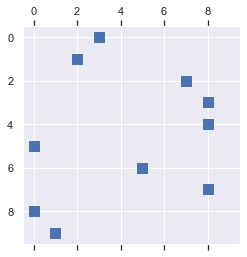

In [33]:
#DGP1 with the random network
W1 = np.zeros((N, N))
W1 = network1(N,W1)
Y1 = dgp(k,N,T,rho0,beta0,gamma0,W1,alpha0,alpha1,X,Err)
print(np.shape(Y1))
plt.spy(W1)
para_W = W1.toarray()
print(para_W)






In [34]:
#a snippet to delete the diagonal
def remove_diag(x):
    x_no_diag = np.ndarray.flatten(x)
    x_no_diag = np.delete(x_no_diag, range(0, len(x_no_diag), len(x) + 1), 0)
    x_no_diag = x_no_diag.reshape(len(x), len(x) - 1)
    return x_no_diag

para_WW = remove_diag(para_W)
# print(para_WW)
para_true[:-3] = np.reshape(para_WW,(N*(N-1)))
# print(para_true)

In [35]:
print(para_WW)

[[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]]


# **2. Objective functions and constraints**#

## 2.1 Objectives

In [36]:
#objective functions
#unpenalized gmm
def gmm(para,*args):
    Y, X,p1,p2,p3 = args
    para = np.reshape(para,(N*(N-1)+3))
    rho = para[-3]
    gamma = para[-2]
    beta = para[-1]
    Wlist = para[0:-3]
#     W = W1
    W = reconstruct(Wlist)
    ERR = (eye-rho*W)@np.transpose(Y)-(beta*eye+gamma*W)@np.transpose(X)
    ERR = np.transpose(ERR)
    gnt = np.zeros(N*N)
    for j in range(T):
        temp = np.outer(X[j],ERR[j])
        gnt = gnt+temp.reshape((N*N))

  #weight matrix 
    Weight = np.identity(N*N)
    gnt.reshape((N*N,1))
    return np.transpose(gnt)@Weight@gnt


#def unpenalized mle   
#assume the little sigma =1 
def mle(para,*args):
  Y, X,p1,p2,p3 = args
  para = np.reshape(para,(N*(N-1)+3))
  rho = para[-3]
  gamma = para[-2]
  beta = para[-1]
  Wlist = para[0:-3]
  W = reconstruct(Wlist)

  ERR = (eye-rho*W)@np.transpose(Y)-(beta*eye+gamma*W)@np.transpose(X)
  ERR = np.transpose(ERR)
  tllk=0
  for i in range(T):
    error = np.reshape(ERR[i],(N,1))
    tllk = tllk-0.5*N*math.log(2*math.pi)-0.5*np.transpose(error)@error
  
  llk = tllk/T

  return -llk.item()
  
#define the penalty functions
def lasso_s1(para,*args):
  Y, X,p1,p2,p3 = args
  Wlist = para[0:-3]
  lasso_pen = 0
  for i in range(len(Wlist)):
    lasso_pen = lasso_pen + (abs(Wlist[i]))
  return p1*lasso_pen

def lasso_s2(para,*args):
  Y, X,p1,p2,p3= args
  Wlist = para[0:-3]
  lasso_pen = 0
  for i in range(len(Wlist)):
    lasso_pen = lasso_pen + (abs(Wlist[i]))
  return p2*lasso_pen


def lasso_s3(para,*args):
  Y, X,p1,p2,p3= args
  Wlist = para[0:-3]
  lasso_pen = 0
  for i in range(len(Wlist)):
    lasso_pen = lasso_pen + (Wlist[i])
  return p2*lasso_pen




def elsn_s1(para,*args):
  Y, X,p1,p2,p3 = args
  Wlist = para[0:-3]
  lasso_pen = 0
  ridge_pen = 0
  for i in range(len(Wlist)):
    lasso_pen = lasso_pen + p1*(abs(Wlist[i]))
    ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
  return ridge_pen+lasso_pen


def elsn_s2(para,*args):
  Y, X,p1,p2,p3 = args
  Wlist = para[0:-3]
  lasso_pen = 0
  ridge_pen = 0
  for i in range(len(Wlist)):
    	lasso_pen = lasso_pen + p2*(abs(Wlist[i]))
    	ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
  return ridge_pen+lasso_pen


def elsn_s3(para,*args):
    Y, X,p1,p2,p3 = args
    Wlist = para[0:-3]
    lasso_pen = 0
    ridge_pen = 0
    for i in range(len(Wlist)):
        lasso_pen = lasso_pen + p1*(Wlist[i])
        ridge_pen = ridge_pen + p3*(Wlist[i]*Wlist[i])
    
    return ridge_pen+lasso_pen
  
  
  
def gmm_pen(para,*args):
	return (1+p2/T)*(gmm(para,*args)+ elsn_s3(para,*args))

# def mle_pen(para,*args):
#   return (1+p2/T)*(mle(para,*args)+ elsn_s1(para,*args))


## 2.2 Constraints 

In [37]:
e = 10**(-5)
#constraint1--Assumption2
def cons0(para,*args):
	Y, X,p1,p2,p3 = args
	rho = para[-3]
	return 1-rho-e

# def cons1(para):
#   rho = para[-3]
#   Wlist = para[0:-4]
#   W = reconstruct(Wlist)
#   return 1-np.sum(np.abs(rho*W[i]))-e  

#Assumption3
def cons3a(para,*args):
	Y, X,p1,p2,p3 = args
	rho = para[-3]
	gamma = para[-2]
	beta = para[-1]
	return beta*rho+gamma-e

def cons3b(para,*args):
	Y, X,p1,p2,p3 = args
	rho = para[-3]
	gamma = para[-2]
	beta = para[-1]
	return -(beta*rho+gamma-e)

#Assumption4, like a regularization assumption(lets say i = 0)
def cons4(para,*args):
	Y, X,p1,p2,p3 = args
	Wlist = para[0:-3]
	W = reconstruct(Wlist)
	return np.sum(W[0])-1-e


#Assumption 5
def cons5a(para,*args):
	Y, X,p1,p2,p3 = args
	Wlist = para[0:-3]
	W = reconstruct(Wlist)
	W2 = W@W
	diag = np.diag(W2)
	return diag[0]-diag[1]-e

def cons5b(para,*args):
	Y, X,p1,p2,p3 = args
	Wlist = para[0:-3]
	W = reconstruct(Wlist)
	W2 = W@W
	diag = np.diag(W2)
	return -(diag[0]-diag[1]-e)



def all_constraints(para,*args):
	a2a = cons0(para,*args)
	a3a = cons3a(para,*args)
	a3b = cons3b(para,*args)
	a4 = cons4(para,*args)
	a5a = cons5a(para,*args)
	a5b = cons5b(para,*args)
	return [a2a,a3a,a3b,a4,a5a,a5b]



# **3. Algorithm Implementation**

In [38]:
from scipy.optimize import minimize
import math 

[ 0  1  2  3  4  5  0  6  7  8  9 10  0 11 12 13 14 15  0 16 17 18 19 20
  0]
[[ 0  1  2  3  4]
 [ 5  0  6  7  8]
 [ 9 10  0 11 12]
 [13 14 15  0 16]
 [17 18 19 20  0]]
  (0, 3)	1.0
  (1, 2)	1.0
  (2, 7)	1.0
  (3, 8)	1.0
  (4, 8)	1.0
  (5, 0)	1.0
  (6, 5)	1.0
  (7, 8)	1.0
  (8, 0)	1.0
  (9, 1)	1.0


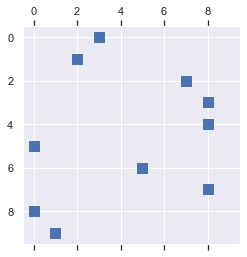

In [39]:
# a test for the matrix construction snippet 
test = np.arange(20)+1
for i in range(5):
    test= np.insert(test,i*6,0)
print(test)
testmatrix = test.reshape((5,5),order='C')
print(testmatrix)
test = np.arange(20)

#the matrix construction snippet 
def reconstruct(Wlist):
  for i in range(N):
    Wlist=np.insert(Wlist,i*(N+1),0)
  # print(Wlist)
  # print(np.shape(Wlist))
  W = Wlist.reshape((N,N))
  sW = sparse.csr_matrix(W)
  return sW

#test 
testt = reconstruct(para_WW)
print(testt)
plt.spy(testt)
# np.sum(testt,axis=0)

## 3.1 Sequential Quadratic Programming for nonlinear constrained optimization

In [40]:
print(para_true)
para_initial = para_true.copy()
para_initial[-3:]=np.array([0,0,0])
# para_initial = np.zeros(len(para_true))
print(para_initial)

[0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
 0.3 0.5 0.4]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# 4. Simulation results

## 4.1 Unconstrained optimization

In [41]:
from scipy.optimize import minimize

In [42]:
maxiter=300
p1=0.5
p2=0.5
p3=0.01

res_gmm = minimize(gmm,x0= para_initial,args=(Y1,X,p1,p2,p3), method='BFGS',options={'disp': True, 'maxiter': 1000})
# res_gmm_pen = minimize(gmm_pen,x0= para_initial,args=(Y1,X,p1,p2,p3), method='BFGS',options={'disp': True})
# res_mle = minimize(mle,x0= para_initial,args=(Y1,X), method='BFGS',options={'disp': True})
print(LA.norm(para_true-res_gmm.x))
# print(LA.norm(para_true-res_gmm_pen.x))
# print(LA.norm(para_true-res_mle.x))
print(res_gmm.x)
# print(res_mle.x)



# para_unp = res_mle.x
# test_para, test_error = LQA(X,Y1,0.01)
# print(test_para)
# print(para_unp)

         Current function value: 322.394456
         Iterations: 117
         Function evaluations: 17766
         Gradient evaluations: 189
1.7039905011409662
[ 0.00754535 -0.08523365  0.54720935 -0.18208065  0.03939176 -0.09397613
  0.29876955 -0.29920095 -0.04755135  0.10522902  0.61881143 -0.02970225
 -0.08472191 -0.02449636 -0.04079729 -0.18344508  0.14017589  0.02186289
 -0.01436784  0.14127652 -0.05690666  0.0248586  -0.11934145  0.01534824
  0.48464224  0.05571742 -0.02656202 -0.22825996  0.05195993  0.16269302
  0.05868978  0.04629385 -0.00545882 -0.23514691  0.9433136  -0.04486679
 -0.03976269  0.03856612 -0.09320157  0.03919637 -0.02019762  0.01129917
  0.1563625   0.32125718 -0.11725622  0.69904724 -0.19872517  0.11076054
  0.01306155 -0.01177589  0.01810534  0.05008243 -0.12908756  0.04098514
 -0.18082864 -0.12639396  0.22662342  0.09594319 -0.01661123  0.60118383
 -0.05871848 -0.05794407  0.04093896 -0.10255039  0.16475733 -0.15109545
 -0.06557387  0.08043651 -0.03237891 

In [43]:
test_para = res_gmm.x
print(test_para)
rWlist = test_para[0:-3]
rW = reconstruct(rWlist)
print(rW)


[ 0.00754535 -0.08523365  0.54720935 -0.18208065  0.03939176 -0.09397613
  0.29876955 -0.29920095 -0.04755135  0.10522902  0.61881143 -0.02970225
 -0.08472191 -0.02449636 -0.04079729 -0.18344508  0.14017589  0.02186289
 -0.01436784  0.14127652 -0.05690666  0.0248586  -0.11934145  0.01534824
  0.48464224  0.05571742 -0.02656202 -0.22825996  0.05195993  0.16269302
  0.05868978  0.04629385 -0.00545882 -0.23514691  0.9433136  -0.04486679
 -0.03976269  0.03856612 -0.09320157  0.03919637 -0.02019762  0.01129917
  0.1563625   0.32125718 -0.11725622  0.69904724 -0.19872517  0.11076054
  0.01306155 -0.01177589  0.01810534  0.05008243 -0.12908756  0.04098514
 -0.18082864 -0.12639396  0.22662342  0.09594319 -0.01661123  0.60118383
 -0.05871848 -0.05794407  0.04093896 -0.10255039  0.16475733 -0.15109545
 -0.06557387  0.08043651 -0.03237891  0.08299246  0.76126613  0.06138788
  0.87555017 -0.19872603 -0.01936364 -0.02953568  0.08079819 -0.06125993
 -0.18887762 -0.22816973  0.09895865 -0.02949626  0

Text(0.5, 1.0, 'Unregularized')

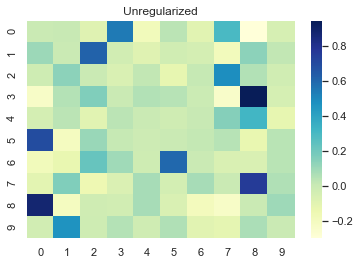

In [44]:
import seaborn as sns; 
sns.set_theme()
ax1 = sns.heatmap(rW.A, cmap="YlGnBu")
# ax2 = sns.heatmap(W1.A, cmap="YlGnBu")
plt.title('Unregularized')

## 4.2 Constrained optimization

In [45]:
def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -numpy.vstack([A, G]).T
        qp_b = -numpy.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

In [46]:
#define boundaries 
from scipy.optimize import Bounds
lower = np.zeros(len(para_true))
lower[-1] = -np.inf
lower[-2] = -np.inf
# print(lower)
upper = np.ones(len(para_true))*np.inf
# print(upper)
bounds = Bounds(lower,upper)
print(bounds)

Bounds(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0., -inf, -inf]), array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf

In [47]:
#define constraints 
# def cons3a(para,*args):
# 	Y, X,p1,p2,p3 = args
#     Wlist = para[0:-3]
# 	W = reconstruct(Wlist)
    
# 	return 

In [48]:
def gmm_lasso(para,*args):
	return (1+p2/T)*(gmm(para,*args)+ lasso_s3(para,*args))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4165.94391834537
            Iterations: 270
            Function evaluations: 25680
            Gradient evaluations: 266
1.1981819239152154
[1.35926590e-01 4.14639053e-06 7.46099876e-01 7.77603326e-06
 1.79717229e-06 3.13192295e-06 2.60416536e-01 4.78948707e-07
 6.41942929e-02 2.13269127e-01 8.13190376e-01 1.21749283e-06
 5.63313867e-06 2.80075330e-06 2.18904192e-06 1.38409501e-06
 1.10868456e-01 3.00540279e-02 3.97641244e-08 2.65705119e-01
 2.79705516e-06 1.74021050e-02 2.84383470e-06 4.79379383e-07
 7.04948523e-01 3.12159974e-01 2.62991948e-08 2.56604117e-01
 4.26270051e-07 1.49657706e-01 6.14440906e-02 2.20667948e-02
 1.03228625e-06 6.60229289e-06 1.08620487e+00 1.28250575e-06
 8.04104791e-02 2.77976142e-02 2.86608178e-06 1.38160335e-01
 1.22622675e-06 9.40426925e-07 1.59831816e-01 5.82585417e-01
 2.83118265e-06 8.70579757e-01 1.97323413e-06 5.64183867e-02
 2.39335887e-01 9.91588345e-07 9.193

Text(0.5, 1.0, 'LASSO')

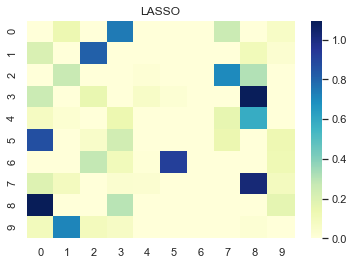

In [49]:
res_gmm_lasso = minimize(gmm_lasso ,x0= para_initial,args=(Y1,X,p1,p2,p3), method='SLSQP',options={'ftol': 1e-9, 'disp': True, 'maxiter': 1000}, bounds =bounds)
print(LA.norm(para_true-res_gmm_lasso.x))
print(res_gmm_lasso.x)
para_lasso = res_gmm_lasso.x
print(para_lasso[-3:])
rWlist_lasso = para_lasso[0:-3]
rW_lasso = reconstruct(rWlist_lasso)
print(rW_lasso)
ax = sns.heatmap(rW_lasso.A, cmap="YlGnBu")
plt.title('LASSO')

In [50]:
res_gmm_pen = minimize(gmm_pen ,x0= para_initial,args=(Y1,X,p1,p2,p3), method='SLSQP',options={'ftol': 1e-9, 'disp': True, 'maxiter': 1000}, bounds =bounds)
print(LA.norm(para_true-res_gmm_pen.x))
print(res_gmm_pen.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4165.750106814379
            Iterations: 314
            Function evaluations: 29945
            Gradient evaluations: 310
1.2123552841573455
[1.30517192e-01 2.35362578e-06 7.15876708e-01 4.41347180e-06
 1.01975699e-06 1.77741010e-06 2.50307554e-01 2.71572934e-07
 6.10562073e-02 2.04183725e-01 7.80912944e-01 6.90885659e-07
 3.19853808e-06 1.58998930e-06 1.24276608e-06 7.85708142e-07
 1.07645065e-01 2.92681704e-02 2.19868634e-08 2.54985008e-01
 1.58807982e-06 1.67722555e-02 1.61318413e-06 2.71312729e-07
 6.76416238e-01 2.99552192e-01 7.54882291e-04 2.46584841e-01
 2.41084275e-07 1.43601484e-01 5.92589582e-02 2.09610663e-02
 5.86335852e-07 3.74874331e-06 1.04260740e+00 7.27549522e-07
 7.71289490e-02 2.74281665e-02 1.62676292e-06 1.32492137e-01
 6.95854474e-07 5.33877514e-07 1.52967023e-01 5.59809194e-01
 1.60581054e-06 8.36358594e-01 1.11981311e-06 5.41190408e-02
 2.29105451e-01 5.61086732e-07 5.20

Text(0.5, 1.0, 'Original')

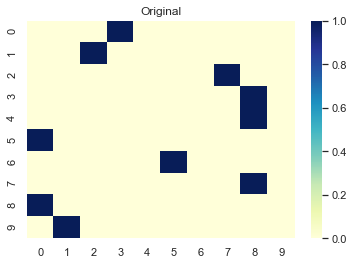

In [51]:
ax2 = sns.heatmap(W1.A, cmap="YlGnBu")
plt.title('Original')

[0.11983754 0.75743002 0.44425138]
  (0, 1)	0.1305171915863094
  (0, 2)	2.3536257846740304e-06
  (0, 3)	0.7158767077162288
  (0, 4)	4.41347179725376e-06
  (0, 5)	1.0197569927178092e-06
  (0, 6)	1.7774100963371582e-06
  (0, 7)	0.2503075535508798
  (0, 8)	2.715729335267341e-07
  (0, 9)	0.06105620728766931
  (1, 0)	0.20418372487845998
  (1, 2)	0.7809129441432863
  (1, 3)	6.908856585776892e-07
  (1, 4)	3.1985380770301716e-06
  (1, 5)	1.5899893019882768e-06
  (1, 6)	1.2427660817826295e-06
  (1, 7)	7.857081424533193e-07
  (1, 8)	0.10764506517368777
  (1, 9)	0.029268170365708782
  (2, 0)	2.198686335500618e-08
  (2, 1)	0.2549850083887328
  (2, 3)	1.5880798190957137e-06
  (2, 4)	0.016772255528884828
  (2, 5)	1.6131841338146149e-06
  (2, 6)	2.7131272860918346e-07
  (2, 7)	0.6764162382782146
  :	:
  (7, 2)	1.9747827092256627e-06
  (7, 3)	0.03669375598445861
  (7, 4)	0.032515841705975865
  (7, 5)	6.320306865429912e-07
  (7, 6)	1.1557013597274817e-07
  (7, 8)	0.9842720339662753
  (7, 9)	0.089201140

Text(0.5, 1.0, 'Elastic Net')

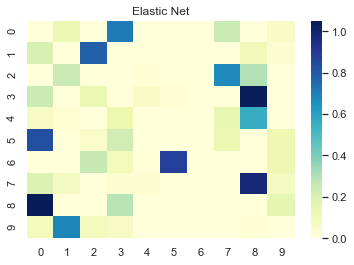

In [52]:
para_pen = res_gmm_pen.x
print(para_pen[-3:])
rWlist_pen = para_pen[0:-3]
rW_pen = reconstruct(rWlist_pen)
print(rW_pen)
ax3 = sns.heatmap(rW_pen.A, cmap="YlGnBu")
plt.title('Elastic Net')